<a href="https://colab.research.google.com/github/kanishkbjain/TEI_HockeyPrediction/blob/main/notebooks/NN_log_rf_ada_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Sorry, I did this in Colab for the GPU speedup while training, but it means the files aren't in the right place for you guys

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Boilerplate imports

In [2]:
#allows drawing digrams in jupyeter notebooks
%matplotlib inline
#loading tensorboard
%load_ext tensorboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#specific tensorflow libraries
import tensorflow as tf
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import datetime

In [5]:
from pandas.plotting import scatter_matrix

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Normalization and scaling

In [7]:
def Train_Test_XY_normalize_PCA(TrainX, TrainY, TestX, PCA_n = None):
    
    # normalize data
    scaler_new = StandardScaler()
    scaler_new.fit(TrainX)
    X_train_scale = scaler_new.transform(TrainX)
    X_test_scale_list = [scaler_new.transform(TestX_now) for TestX_now in TestX]

    print(f'X shape {X_train_scale.shape}')
    
    if PCA_n != None:
        # dimension reduction
        pca = PCA(n_components=PCA_n)
        TrainX_PCA = pca.fit(X_train_scale)
        TrainX_PCA = pca.transform(TrainX_PCA)
        TestX_PCA_list = [pca.transform(TestX_now) for TestX_now in TestX]

        print(f'X shape {TrainX_PCA.shape}')
    
        # normalize again
        scaler_new = StandardScaler()
        scaler_new.fit(TrainX_PCA)
        X_train_scale = scaler_new.transform(TrainX_PCA)
        X_test_scale = [scaler_new.transform(TestX_now) for TestX_now in TestX_PCA_list]


        #Delete dis
    return X_train_scale, 0, TrainY, 0, X_test_scale_list     
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_scale,TrainY,
                                                       test_size=.0,
                                                       shuffle=True,
                                                       random_state=2020,
                                                       stratify=TrainY)
    
    #return X_train, X_val, y_train, y_val, X_test_scale_list

In [8]:
import tensorflow.keras.backend as Kb

# Write a custom loss function
def custom_loss(y_true, y_pred):
    binary_crossentropy = Kb.mean(Kb.binary_crossentropy(y_true, y_pred), axis = -1)
    prob_constraint = Kb.square(Kb.sum(y_pred, axis = -1)
                                - Kb.sum(y_true, axis = -1))

    return(binary_crossentropy+prob_constraint)

In [26]:
def NN_TF_model(structure, ipt_dim, learning_rate=0.01):
    model=Sequential()

    model.add(layers.Dense(structure[0], input_shape=(ipt_dim,), activation='relu'))
    
    for i in range(len(structure)-1):
        model.add(layers.Dense(structure[i+1], activation='relu'))
        #model.add(layers.Dropout(0.2))
        
    model.add(layers.Dense(1, activation='sigmoid'))

    # opt = optimizers.SGD(learning_rate=0.01)
    #opt = optimizers.Adam(learning_rate=0.01)
    opt = optimizers.Nadam(learning_rate=0.01)

    # model.compile(loss='mean_squared_error', optimizer=opt)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    # model.compile(loss=custom_loss, optimizer=opt)
    # model.compile(loss='huber', optimizer=opt)
    # model.compile(loss='binary_focal_crossentropy', optimizer=opt)
    print(model.summary())
    
    return model

# Models

We can change what features we want to include: player? team? both?

In [27]:
# see_column = np.array(['Rk', 'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%',
#        'GF', 'GA', 'SOW', 'SOL', 'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO',
#        'PP%', 'PPA', 'PPOA', 'PK%', 'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%',
#        'SA', 'SV%', 'SO', 'Hits', 'Hits/60', 'BkS', 'BkS/60', 'GvA', 'GvA/60',
#        'TkA', 'TkA/60', 'ENG', 'MsS', '5v5 TOI/GP', 'SAT%', 'Playoffs%',
#        'Playoffs', 'WonCup', 'TA/GA'])

see_column = np.array(['PTS', 'W','L', 'GF', 'GA', 'SRS', 
                                  'SOS', 'PK%', 'S%', 'SV%', 'SAT%', 
                                  'MsS', 'TA/GA'])
# see_column = np.array(['W', 'L', 'GA', 'SAT%', 'TA/GA'])

see_column2 = np.array(['Winner',
                       'F_home_assists', 'F_home_goals', 'F_home_pim', 'F_home_shots',
                       'F_home_blocked', 'F_home_hits', 'F_home_pm', 'D_home_assists', 'D_home_goals',
                       'D_home_pim', 'D_home_shots', 'D_home_blocked', 'D_home_hits',
                       'D_home_pm', 'G_home_GAA', 'F_away_assists', 'F_away_goals', 'F_away_pim', 'F_away_shots',
                       'F_away_blocked', 'F_away_hits', 'F_away_pm', 'D_away_assists', 'D_away_goals',
                       'D_away_pim', 'D_away_shots', 'D_away_blocked', 'D_away_hits',
                       'D_away_pm', 'G_away_GAA'])


column_home = np.array([i+'_H' for i in see_column])
column_away = np.array([i+'_A' for i in see_column])

column_name = np.concatenate((column_home,column_away))

column_name = np.concatenate((see_column2,column_name))
#  column_name = np.concatenate((column_name,['class'])) # Winner is the class

# ## only consider tm data
# column_home = np.array([i+'_H' for i in see_column])
# column_away = np.array([i+'_A' for i in see_column])
# column_name = np.concatenate((column_home,column_away))
# column_name = np.concatenate((['Winner'],column_name)) # Winner is the class

## only consider players data
column_name = see_column2

print(column_name)

['Winner' 'F_home_assists' 'F_home_goals' 'F_home_pim' 'F_home_shots'
 'F_home_blocked' 'F_home_hits' 'F_home_pm' 'D_home_assists'
 'D_home_goals' 'D_home_pim' 'D_home_shots' 'D_home_blocked' 'D_home_hits'
 'D_home_pm' 'G_home_GAA' 'F_away_assists' 'F_away_goals' 'F_away_pim'
 'F_away_shots' 'F_away_blocked' 'F_away_hits' 'F_away_pm'
 'D_away_assists' 'D_away_goals' 'D_away_pim' 'D_away_shots'
 'D_away_blocked' 'D_away_hits' 'D_away_pm' 'G_away_GAA']


#### Train NN model

In [147]:
#You have to change these inputs back to what Chenyi had
tm_players = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Erdos Institute Final Project - SKYLAB/Data/tm_player_stats_2005_2021.csv')
playoff = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Erdos Institute Final Project - SKYLAB/Data/playoff_stats_2005_2021.csv')
playoff_test = playoff[:-87]
playoff_temp = playoff[1436:1509]
#playoff_pred = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Erdos Institute Final Project - SKYLAB/Data/AllMatchups.csv')

tm_players[column_name].sample(1)

,Winner,F_home_assists,F_home_goals,F_home_pim,F_home_shots,F_home_blocked,F_home_hits,F_home_pm,D_home_assists,D_home_goals,...,F_away_hits,F_away_pm,D_away_assists,D_away_goals,D_away_pim,D_away_shots,D_away_blocked,D_away_hits,D_away_pm,G_away_GAA
11523,0,1.025894,0.812123,3.910935,7.668899,1.910511,5.675656,-0.008968,0.992456,0.240191,...,5.335802,-0.047565,0.7556,0.174941,2.704355,4.452401,4.337999,3.389377,0.218237,2.914226


Create train and test sets.

Additionally, come up with a set of every team playing every other team for prediction purposes X_pred

In [148]:
# Traindf_diff = pd.DataFrame(data = Traindf[column_home].to_numpy() 
#                                     - Traindf[column_away].to_numpy(), 
#                             columns = see_column)

#Data from regular season: 2005-2021
Traindf = tm_players[column_name]
TrainX_array = Traindf[column_name[1:]].to_numpy()
TrainY_array = Traindf[column_name[0]].to_numpy()

#Data from playoffs: 2005-2020
Testdf = playoff_test[column_name]
TestX_array = Testdf[column_name[1:]].to_numpy()
TestY_array = Testdf[column_name[0]].to_numpy()
y_test = TestY_array

#Data from playoffs: 2021
tempdf = playoff_temp[column_name] 
tempX_array = tempdf[column_name[1:]].to_numpy()


#Don't have y_pred because we don't know who won in 2021 yet
#y_pred = Preddf[column_name[0]].to_numpy()


In [149]:
home_cols = np.array(['homeAbbrev', 'F_home_assists', 'F_home_goals', 'F_home_pim', 'F_home_shots',
                       'F_home_blocked', 'F_home_hits', 'F_home_pm', 'D_home_assists', 'D_home_goals',
                       'D_home_pim', 'D_home_shots', 'D_home_blocked', 'D_home_hits',
                       'D_home_pm', 'G_home_GAA'])

NN_cols = np.array(['F_home_assists', 'F_home_goals', 'F_home_pim', 'F_home_shots',
                       'F_home_blocked', 'F_home_hits', 'F_home_pm', 'D_home_assists', 'D_home_goals',
                       'D_home_pim', 'D_home_shots', 'D_home_blocked', 'D_home_hits',
                       'D_home_pm', 'G_home_GAA'])

In [150]:
TeamList = ['COL', 'NSH', 'MIN', 'STL', 'CGY', 'DAL', 'EDM', 'LAK', 'FLA', 'WSH', 'TOR', 'TBL', 'CAR', 'BOS', 'NYR', 'PIT']

#This is the data from the most recent game we have data available for
dfs = [(playoff_temp[home_cols].loc[(playoff_temp.homeAbbrev == team)].tail(1)) for team in TeamList]
TeamAverages = pd.concat(dfs, ignore_index = True)
TeamAverages

,homeAbbrev,F_home_assists,F_home_goals,F_home_pim,F_home_shots,F_home_blocked,F_home_hits,F_home_pm,D_home_assists,D_home_goals,D_home_pim,D_home_shots,D_home_blocked,D_home_hits,D_home_pm,G_home_GAA
0,COL,1.354877,0.897446,1.693630,7.865989,2.007970,4.694978,0.483299,1.012747,0.377212,1.725935,4.977005,3.666825,4.881980,0.618378,3.079092
1,NSH,1.147841,0.864018,2.642927,6.676903,2.109020,7.565427,-0.011657,0.869903,0.188685,3.097599,4.577687,4.089691,5.819146,-0.028379,3.179254
2,MIN,1.454759,0.871291,3.463298,8.113439,1.710650,7.158114,0.428524,0.802816,0.241591,1.353866,3.969292,4.108469,3.713037,0.903035,2.904200
3,STL,1.610160,1.099073,1.337461,7.288217,1.554599,3.899510,0.317211,0.927065,0.247134,1.522250,4.026448,3.868756,3.642786,0.276109,2.846504
4,CGY,1.270271,1.002407,1.804618,8.304612,1.407937,5.228458,0.708209,1.059640,0.248739,1.857672,5.465385,3.756104,4.240612,0.683349,2.224100
5,DAL,0.977506,0.709077,1.346791,6.725738,2.068485,5.346605,-0.454931,0.789127,0.180640,1.113347,4.233014,3.808293,3.781154,-0.309382,2.526200
6,EDM,1.270053,0.930354,2.022099,7.384278,1.295797,6.416885,0.395703,0.863851,0.225268,1.137328,5.099719,4.318837,4.659886,-0.601595,2.712707
7,LAK,0.951035,0.873424,1.903912,8.545825,1.639262,4.187482,0.013353,0.674483,0.104678,1.027555,4.446804,4.229748,4.207890,0.205611,2.591300
8,FLA,1.644462,1.140087,2.132880,8.435701,1.585193,4.890510,0.854797,0.920505,0.306456,1.981336,5.470553,4.065651,6.073890,0.694921,3.548598
9,WSH,1.238918,0.859159,1.728240,7.078066,1.956336,5.427952,-0.045069,0.835282,0.301264,1.486159,4.583104,4.432774,4.906950,0.270857,3.062784


In [151]:
dfs_home = [(TeamAverages[NN_cols].loc[i].to_numpy()) for i in range(len(TeamAverages)) for j in range(len(TeamAverages))]
dfs_away = [(TeamAverages[NN_cols].loc[j].to_numpy()) for i in range(len(TeamAverages)) for j in range(len(TeamAverages))]
                                                                         
new_home = np.vstack(dfs_home)
new_away = np.vstack(dfs_away)
X_pred = np.hstack((new_home, new_away))
#This has 16*16 columns in it: one for every possible matchup between teams
X_pred

PredX_array = X_pred

In [152]:
X_train, X_val, y_train, y_val, [X_pred, X_test, X_temp] = Train_Test_XY_normalize_PCA(TrainX_array, 
                                                                    TrainY_array, 
                                                                   # TestX_array)                                                                     
                                                                     [PredX_array, TestX_array, tempX_array])



X shape (20050, 30)


PCA Doesn't help. Skip it

In [34]:
#pca = PCA(n_components=0.9)
#pca.fit(X_train)
#X_train = pca.transform(X_train)
#X_val = pca.transform(X_val)
#X_test = pca.transform(X_test)
#X_pred = pca.transform(X_pred)
#X_temp = pca.transform(X_temp)

##Neural Network model

In [69]:
#creating unique name for tensorboard directory
log_dir = "logs/NN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#Tensforboard callback function
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tf.keras.utils.set_random_seed(973)

struct = [30,30]
dim = X_train.shape[1]
model = NN_TF_model(structure = struct, ipt_dim = dim)
history = model.fit(X_train,
                  y_train,
                  validation_split = 0.2,
                  epochs=200,
                  batch_size=100,
                  shuffle=True,
                  callbacks=[tensorboard_callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 30)                930       
                                                                 
 dense_16 (Dense)            (None, 30)                930       
                                                                 
 dense_17 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
161/161 [==============================] - 2s 5ms/step - loss: 0.6582 - accuracy: 0.6076 - val_loss: 0.6523 - val_accuracy: 0.6100
Epoch 2/200
161/161 [==============================] - 1s 4ms/step - loss: 0.6477 - accuracy: 0.6182 - val_loss: 0.6531 - val_accuracy: 0.6172
Epoch 3/200
161/161 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


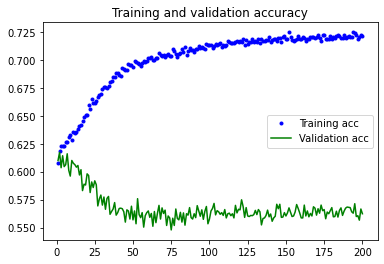

In [70]:
model.test_on_batch(X_test, y_test)
model.metrics_names
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b.', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'b.', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

plt.show()

In [71]:
m = metrics.Accuracy()
mc = metrics.CategoricalAccuracy()

In [72]:
y_hat=model.predict(X_train)>0.5
y_hat=np.squeeze(y_hat)*1

In [73]:
m.update_state(y_train, y_hat)
mc.update_state(y_train, y_hat)
print('away win rate = ', sum(y_hat)/len(y_hat))
print('Train data accuracy',m.result().numpy())
# print('Train data categorical accuracy',mc.result().numpy())
tf.math.confusion_matrix(y_train, y_hat)

away win rate =  0.5272319201995013
Train data accuracy 0.69426435


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[7154, 3805],
       [2325, 6766]], dtype=int32)>

In [74]:
#No separate validation set when using the full model
#y_hat=model.predict(X_val)>0.5
#y_hat=np.squeeze(y_hat)*1

In [75]:
#m.update_state(y_val, y_hat)
#print('away win rate = ',sum(y_hat)/len(y_hat))
#print('Test data accuracy',m.result().numpy())
#tf.math.confusion_matrix(y_val, y_hat)

In [76]:
y_hat=model.predict(X_test)>0.5
y_hat=np.squeeze(y_hat)*1

In [77]:
m.update_state(y_test, y_hat)
print('away win rate = ',sum(y_hat)/len(y_hat))
print('Test data accuracy',m.result().numpy())
tf.math.confusion_matrix(y_test, y_hat)

away win rate =  0.46373779637377965
Test data accuracy 0.6826475


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[428, 347],
       [341, 318]], dtype=int32)>

In [53]:
def SeriesProb(model_prediction):
    win = model_prediction
    lose = 1-model_prediction
    return win**4 * 1 + win**4 * lose**1 * 4 + win**4 * lose**2 * 10 + win**4 *  lose**3 * 20

In [54]:
SeriesProb(model.predict(X_pred)).shape

(256, 1)

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

In [91]:
## make the kfold object
kfold = StratifiedKFold(5, random_state = 42, shuffle = True)


ho_avgs = np.zeros(5)
test_avgs = np.zeros(5)


i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train[train_index], y_train[test_index]


    
    ## Make the pipeline here
    #pipe = Pipeline([('scale', StandardScaler()),
    #                 ('log', LogisticRegression())])
    #pipe = Pipeline([('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
    #                         n_estimators = 50, #The more estimators we use, the higher the training accuracy and lower the testing accuracy.
    #                         learning_rate = 1,
    #                         random_state = 2906))])
    #pipe = Pipeline([('rf', RandomForestClassifier(n_estimators = 200,
    #                            max_depth = 2))])
    #pipe = Pipeline([('dt', DecisionTreeClassifier())])

    ## fit the pipeline
    pipe.fit(X_tt, y_tt)
    
    cutoff = 0.5
    ## predict on the holdout set
    y_hat_ho=np.squeeze(pipe.predict_proba(X_ho)[:,1]>cutoff)*1 
    y_hat_test=np.squeeze(pipe.predict_proba(X_test)[:,1]>cutoff)*1 

    ho_avgs[i] = accuracy_score(y_hat_ho, y_ho)
    test_avgs[i] = accuracy_score(y_hat_test, y_test)
    

    i = i + 1

print(np.mean(ho_avgs))
print(np.mean(test_avgs))

NameError: ignored

##Logistic Regression model

In [92]:
log = LogisticRegression(random_state=4).fit(X_train, y_train)
#np.hstack((log.predict(X_test), np.round(model.predict(X_test))))

In [93]:
log.score(X_train, y_train)

0.6224438902743142

In [94]:
#No validation set when training the final model
#log.score(X_val, y_val)

In [95]:
log.score(X_test, y_test)

0.5285913528591353

##AdaBoost model

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [97]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2, random_state = 43210),
                             n_estimators = 10, #The more estimators we use, the higher the training accuracy and lower the testing accuracy.
                             learning_rate = 1,
                             random_state = 2906)

In [98]:
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=43210),
                   learning_rate=1, n_estimators=10, random_state=2906)

In [99]:
ada.score(X_train, y_train)

0.6228927680798005

In [100]:
#No validation set when training the final model
#ada.score(X_val, y_val)

In [101]:
ada.score(X_test, y_test)

0.5327754532775453

##Random Forest model

In [102]:
rf = RandomForestClassifier(n_estimators = 500,
                                max_depth = 5)

In [103]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [104]:
rf.score(X_train, y_train)

0.6295261845386534

In [105]:
#No validation set when training the final model
#rf.score(X_val, y_val)

In [106]:
rf.score(X_test, y_test)

0.5439330543933054

#Find winning teams: Results

In [159]:
#X_pred = X_test
pred = np.zeros((4,len(X_pred)))

In [160]:
pred[0] = np.reshape(model.predict(X_pred), -1)
pred[1] = log.predict_proba(X_pred)[:,1]
pred[2] = ada.predict_proba(X_pred)[:,1]
pred[3] = rf.predict_proba(X_pred)[:,1]

In [161]:
all_probs = SeriesProb(np.mean(pred, axis = 0))
all_probs.shape

(256,)

In [146]:
test_probs = np.mean(pred, axis = 0)
y_hat=np.squeeze(test_probs>0.5)*1 

accuracy_score(y_hat, y_t)


0.5334728033472803

In [ ]:
np.ones(8) - SeriesProb(np.mean(pred, axis = 0)) #Probability of home team winning

array([0.89153731, 0.28872631, 0.74592029, 0.5716377 , 0.78158714,
       0.43772545, 0.5170655 , 0.1955171 ])

In [ ]:
Preddf = playoff_pred[column_name]
PredX_array = Preddf[column_name[1:]].to_numpy()

In [ ]:
TeamAverages.to_csv()

',homeAbbrev,F_home_assists,F_home_goals,F_home_pim,F_home_shots,F_home_blocked,F_home_hits,F_home_pm,D_home_assists,D_home_goals,D_home_pim,D_home_shots,D_home_blocked,D_home_hits,D_home_pm,G_home_GAA\n0,COL,1.354877487,0.897446483,1.693629899,7.865988533,2.007969868,4.694978402,0.483298655,1.01274733,0.377212453,1.725934568,4.977004966,3.666825358,4.88198029,0.618378102,3.079092317\n1,NSH,1.147840536,0.864017655,2.642927453,6.676903494,2.109019801,7.565426937,-0.011657052,0.869902561,0.188684924,3.097599196,4.577686611,4.089691224,5.819146186,-0.028378617,3.179254064\n2,MIN,1.454758563,0.871290649,3.463297582,8.113439119,1.710650098,7.158113545,0.428524482,0.802816143,0.241591467,1.353865648,3.969292371,4.108469387,3.713037451,0.903035368,2.9042\n3,STL,1.610159619,1.099072949,1.337460667,7.288216798,1.554598659,3.899510146,0.317211223,0.927065216,0.247134288,1.52225029,4.026447761,3.868756204,3.642786063,0.276109114,2.846504078\n4,CGY,1.270271312,1.002407148,1.804617636,8.304611662,1

In this code:
* create a dataframe of all 16 teams, with 15 points of data each.

*   loop through each pair of teams in the dataframe and predict who'd win a matchup between them.
*   calculate the predicted probabilities of progressing to the final
*   do that with a script and not by hand






In [ ]:
for i in range(len(all_indices)):
    print(TeamAverages.homeAbbrev.loc[all_indices[i,0]], "vs ", TeamAverages.homeAbbrev.loc[all_indices[i,1]])
    print(all_probs[i],'\n\n')

In [78]:
all_probs =  np.reshape(model.predict(X_pred), -1)
#all_probs = log.predict_proba(X_pred)[:,1]
#all_probs = ada.predict_proba(X_pred)[:,1]
#all_probs = rf.predict_proba(X_pred)[:,1]

In [162]:
#my_columns = np.hstack(('home_team',TeamList))
funky_prob_table = pd.DataFrame(columns = [TeamList])
funky_prob_table = pd.DataFrame(all_probs.reshape(-1,16), index = TeamList,columns = funky_prob_table.columns) 
funky_prob_table

,COL,NSH,MIN,STL,CGY,DAL,EDM,LAK,FLA,WSH,TOR,TBL,CAR,BOS,NYR,PIT
COL,0.424484,0.378109,0.603866,0.494253,0.387087,0.431681,0.325324,0.554211,0.338489,0.317382,0.333988,0.183781,0.331562,0.406418,0.346262,0.436084
NSH,0.551401,0.587866,0.421329,0.578173,0.588453,0.385065,0.619882,0.503752,0.603817,0.514783,0.603525,0.290504,0.583435,0.507147,0.542944,0.595895
MIN,0.578137,0.293207,0.401232,0.589728,0.396833,0.360053,0.321580,0.320887,0.580159,0.340727,0.323080,0.178667,0.378379,0.311703,0.340776,0.384604
STL,0.455921,0.405783,0.572191,0.479538,0.506072,0.416888,0.308229,0.548117,0.399711,0.429996,0.362093,0.132032,0.390783,0.360984,0.345006,0.486478
CGY,0.430533,0.420977,0.514769,0.419461,0.426104,0.345027,0.533849,0.407509,0.421037,0.391486,0.452913,0.152777,0.287473,0.278084,0.364370,0.445860
DAL,0.477700,0.345849,0.439031,0.553887,0.604544,0.479324,0.385253,0.558113,0.514442,0.490250,0.495366,0.208605,0.431167,0.618732,0.569724,0.674964
EDM,0.508074,0.323725,0.630234,0.533759,0.554347,0.403722,0.490798,0.607646,0.456530,0.466270,0.539007,0.375969,0.424456,0.364486,0.382929,0.540466
LAK,0.619461,0.376436,0.514524,0.609524,0.679849,0.414262,0.591016,0.500831,0.401336,0.344505,0.376482,0.150414,0.379272,0.513127,0.613678,0.656864
FLA,0.518931,0.483218,0.424435,0.489849,0.545258,0.488715,0.323139,0.344697,0.392210,0.562255,0.333266,0.219403,0.326779,0.376210,0.344517,0.587925
WSH,0.514241,0.383876,0.642633,0.531593,0.520498,0.501976,0.357492,0.600856,0.600043,0.455784,0.449261,0.205824,0.376317,0.529380,0.375864,0.537012


In [163]:
#This is the probability of the home team winning the game
Home_table = pd.DataFrame(np.ones((16,16)) - all_probs.reshape(-1,16), index = TeamList, columns = funky_prob_table.columns) 
Home_table#.to_csv()

,COL,NSH,MIN,STL,CGY,DAL,EDM,LAK,FLA,WSH,TOR,TBL,CAR,BOS,NYR,PIT
COL,0.575516,0.621891,0.396134,0.505747,0.612913,0.568319,0.674676,0.445789,0.661511,0.682618,0.666012,0.816219,0.668438,0.593582,0.653738,0.563916
NSH,0.448599,0.412134,0.578671,0.421827,0.411547,0.614935,0.380118,0.496248,0.396183,0.485217,0.396475,0.709496,0.416565,0.492853,0.457056,0.404105
MIN,0.421863,0.706793,0.598768,0.410272,0.603167,0.639947,0.678420,0.679113,0.419841,0.659273,0.676920,0.821333,0.621621,0.688297,0.659224,0.615396
STL,0.544079,0.594217,0.427809,0.520462,0.493928,0.583112,0.691771,0.451883,0.600289,0.570004,0.637907,0.867968,0.609217,0.639016,0.654994,0.513522
CGY,0.569467,0.579023,0.485231,0.580539,0.573896,0.654973,0.466151,0.592491,0.578963,0.608514,0.547087,0.847223,0.712527,0.721916,0.635630,0.554140
DAL,0.522300,0.654151,0.560969,0.446113,0.395456,0.520676,0.614747,0.441887,0.485558,0.509750,0.504634,0.791395,0.568833,0.381268,0.430276,0.325036
EDM,0.491926,0.676275,0.369766,0.466241,0.445653,0.596278,0.509202,0.392354,0.543470,0.533730,0.460993,0.624031,0.575544,0.635514,0.617071,0.459534
LAK,0.380539,0.623564,0.485476,0.390476,0.320151,0.585738,0.408984,0.499169,0.598664,0.655495,0.623518,0.849586,0.620728,0.486873,0.386322,0.343136
FLA,0.481069,0.516782,0.575565,0.510151,0.454742,0.511285,0.676861,0.655303,0.607790,0.437745,0.666734,0.780597,0.673221,0.623790,0.655483,0.412075
WSH,0.485759,0.616124,0.357367,0.468407,0.479502,0.498024,0.642508,0.399144,0.399957,0.544216,0.550739,0.794176,0.623683,0.470620,0.624136,0.462988


In [135]:
COL = np.zeros(4)
NSH = np.zeros(4)
MIN = np.zeros(4)
STL = np.zeros(4)
CGY = np.zeros(4)
DAL = np.zeros(4)
EDM = np.zeros(4)
LAK = np.zeros(4)
FLA = np.zeros(4)
WSH = np.zeros(4)
TOR = np.zeros(4)
TBL = np.zeros(4)
CAR = np.zeros(4)
BOS = np.zeros(4)
NYR = np.zeros(4)
PIT = np.zeros(4)

In [136]:
#First round, technically
round = 0
current_team = 0 #colorado
COL[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
NSH[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
MIN[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
STL[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
CGY[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
DAL[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
EDM[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
LAK[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
FLA[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
WSH[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
TOR[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
TBL[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
CAR[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
BOS[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]

current_team += 2
NYR[round] = Home_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]
PIT[round] = funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team + 1]]


What is the probability of winning a 2nd round game?

Avalance have an 89% chance of making it to teh 2nd round.

There, they have two possibilities: minnesota or st louis.
The most probable options is they face st. louis and we calculate that probability.

((col vs min) * prob min + (col vs blues) * prob blues) * prob avalance

((min vs ave) * prob ave + (min vs wild) * prob wild) * prob min

(wild * min) * prob min + (wild vs blues) * prob blues    * prob wild

(blues * ave) * prob ave + (blues x wild) * prob wild    * prob blues



In [137]:
#Second round probabilities
round = 1
current_team = 0 #colorado
#nevermind, brain too smol for this
COL[round] = COL[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values * MIN[round-1] 
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * STL[round-1])
NSH[round] = NSH[round - 1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * MIN[round-1] 
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * STL[round-1])
MIN[round] = MIN[round - 1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values * COL[round-1] 
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * NSH[round-1])
STL[round] = STL[round - 1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * COL[round-1] 
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * NSH[round-1])
current_team += 4
CGY[round] = CGY[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values *EDM[round-1] 
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * LAK[round-1])
DAL[round] = DAL[round-1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * EDM[round-1]
                           + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * LAK[round-1])
EDM[round] = EDM[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values * CGY[round-1]
                           + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * DAL[round-1])
LAK[round] = LAK[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * CGY[round-1]
                           + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * DAL[round-1])
current_team += 4
FLA[round] = FLA[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values *TOR[round-1] 
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * TBL[round-1])
WSH[round] = WSH[round-1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * TOR[round-1]
                           + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * TBL[round-1])
TOR[round] = TOR[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values * FLA[round-1]
                           + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * WSH[round-1])
TBL[round] = TBL[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * FLA[round-1]
                           + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * WSH[round-1])
current_team += 4
CAR[round] = CAR[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values *NYR[round-1] 
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * PIT[round-1])
BOS[round] = BOS[round-1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * NYR[round-1]
                           + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * PIT[round-1])
NYR[round] = NYR[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+2]].values * CAR[round-1]
                           + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+2]].values * BOS[round-1])
PIT[round] = PIT[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+3]].values * CAR[round-1]
                           + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+3]].values * BOS[round-1])


for semis, we have avalance vs 4 possible teams

so ave x cal * cal + ave x dal * dal + ave * oil x oil + ave * la * la
all times ave


put simply: prob(team 1 vs team 2)* prob(team 1) * prob(team 2)

In [138]:
#Third round probabilities - SEMIFINALS
round = 2
current_team = 0 #colorado
COL[round] = COL[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+4]].values * CGY[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+5]].values * DAL[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+6]].values * EDM[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+7]].values * LAK[round-1])
NSH[round] = NSH[round - 1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+4]].values * CGY[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+5]].values * DAL[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+6]].values * EDM[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+7]].values * LAK[round-1])
MIN[round] = MIN[round - 1]*(Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+4]].values * CGY[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+5]].values * DAL[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+6]].values * EDM[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+7]].values * LAK[round-1])
STL[round] = STL[round - 1]*(Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+4]].values * CGY[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+5]].values * DAL[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+6]].values * EDM[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+7]].values * LAK[round-1])

CGY[round] = CGY[round - 1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+4]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+4]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+4]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+4]].values * STL[round-1])
DAL[round] = DAL[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+5]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+5]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+5]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+5]].values * STL[round-1])
EDM[round] = EDM[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+6]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+6]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+6]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+6]].values * STL[round-1])
LAK[round] = LAK[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+7]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+7]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+7]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+7]].values * STL[round-1])
current_team += 8
FLA[round] = FLA[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+4]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+5]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+6]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+7]].values * PIT[round-1])
WSH[round] = WSH[round-1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+4]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+5]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+6]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+7]].values * PIT[round-1])
TOR[round] = TOR[round-1]*(Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+4]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+5]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+6]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+7]].values * PIT[round-1])
TBL[round] = TBL[round-1]*(Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+4]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+5]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+6]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+7]].values * PIT[round-1])

CAR[round] = CAR[round - 1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+4]].values * FLA[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+4]].values * WSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+4]].values * TOR[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+4]].values * TBL[round-1])
BOS[round] = BOS[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+5]].values * FLA[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+5]].values * WSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+5]].values * TOR[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+5]].values * TBL[round-1])
NYR[round] = NYR[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+6]].values * FLA[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+6]].values * WSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+6]].values * TOR[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+6]].values * TBL[round-1])
PIT[round] = PIT[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+7]].values * FLA[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+7]].values * WSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+7]].values * TOR[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+7]].values * TBL[round-1])

In [139]:
#Fourth round probabilities - FINALS BABY
round = 3
current_team = 0 #colorado
#This is going to suckass
COL[round] = COL[round - 1]*(Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team]].loc[TeamList[current_team+15]].values * PIT[round-1])

NSH[round] = NSH[round - 1]*(Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+15]].values * PIT[round-1])

MIN[round] = MIN[round - 1]*(Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+15]].values * PIT[round-1])

STL[round] = STL[round - 1]*(Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+15]].values * PIT[round-1])

CGY[round] = CGY[round - 1]*(Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+15]].values * PIT[round-1])

DAL[round] = DAL[round-1]*(Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+15]].values * PIT[round-1])

EDM[round] = EDM[round-1]*(Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+15]].values * PIT[round-1])

LAK[round] = LAK[round-1]*(Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+8]].values * FLA[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+9]].values * WSH[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+10]].values * TOR[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+11]].values * TBL[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+12]].values * CAR[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+13]].values * BOS[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+14]].values * NYR[round-1]
                             + Home_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+15]].values * PIT[round-1])


FLA[round] = FLA[round - 1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+8]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+8]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+8]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+8]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+8]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+8]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+8]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+8]].values * LAK[round-1])

WSH[round] = WSH[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+9]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+9]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+9]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+9]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+9]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+9]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+9]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+9]].values * LAK[round-1])

TOR[round] = TOR[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+10]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+10]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+10]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+10]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+10]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+10]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+10]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+10]].values * LAK[round-1])

TBL[round] = TBL[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+11]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+11]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+11]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+11]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+11]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+11]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+11]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+11]].values * LAK[round-1])

CAR[round] = CAR[round - 1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+12]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+12]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+12]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+12]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+12]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+12]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+12]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+12]].values * LAK[round-1])

BOS[round] = BOS[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+13]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+13]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+13]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+13]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+13]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+13]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+13]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+13]].values * LAK[round-1])

NYR[round] = NYR[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+14]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+14]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+14]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+14]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+14]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+14]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+14]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+14]].values * LAK[round-1])

PIT[round] = PIT[round-1]*(funky_prob_table.loc[TeamList[current_team]].loc[TeamList[current_team+15]].values * COL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+1]].loc[TeamList[current_team+15]].values * NSH[round-1]
                             + funky_prob_table.loc[TeamList[current_team+2]].loc[TeamList[current_team+15]].values * MIN[round-1]
                             + funky_prob_table.loc[TeamList[current_team+3]].loc[TeamList[current_team+15]].values * STL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+4]].loc[TeamList[current_team+15]].values * CGY[round-1]
                             + funky_prob_table.loc[TeamList[current_team+5]].loc[TeamList[current_team+15]].values * DAL[round-1]
                             + funky_prob_table.loc[TeamList[current_team+6]].loc[TeamList[current_team+15]].values * EDM[round-1]
                             + funky_prob_table.loc[TeamList[current_team+7]].loc[TeamList[current_team+15]].values * LAK[round-1])

In [140]:
print('COL',COL)
print('NSH',NSH)
print('MIN',MIN)
print('STL',STL)
print('CGY',CGY)
print('DAL',DAL)
print('EDM',EDM)
print('LAK',LAK)
print('FLA',FLA)
print('WSH',WSH)
print('TOR',TOR)
print('TBL',TBL)
print('CAR',CAR)
print('BOS',BOS)
print('NYR',NYR)
print('PIT',PIT)

COL [0.7423531  0.30232783 0.18564556 0.15139025]
NSH [0.2576469  0.10494867 0.04160056 0.01355967]
MIN [0.22026859 0.1478121  0.12070808 0.09142444]
STL [0.77973141 0.44491141 0.21537069 0.14828921]
CGY [0.77674478 0.45899328 0.19021447 0.12794395]
DAL [0.22325522 0.10321625 0.03642835 0.01555459]
EDM [0.20876129 0.12245666 0.02343919 0.01280272]
LAK [0.79123871 0.31533381 0.18659311 0.11657114]
FLA [0.24410088 0.20668203 0.13528321 0.04661231]
WSH [0.75589912 0.4698956  0.29259225 0.0737937 ]
TOR [0.99817861 0.32340106 0.20380759 0.05633964]
TBL [1.82139092e-03 2.13138345e-05 4.34136463e-06 4.58510825e-08]
CAR [0.62044936 0.34082405 0.05500622 0.01075285]
BOS [0.37955064 0.18391975 0.07408879 0.02227936]
NYR [0.61537844 0.19609612 0.06279189 0.02150891]
PIT [0.38462156 0.27916009 0.17642571 0.09117721]


In [141]:
#np.savetxt("AllMatchups.csv", X_pred, delimiter=",")

In [142]:
Final_probs = np.vstack((COL, NSH, MIN, STL, CGY, DAL, EDM, LAK, FLA, WSH, TOR, TBL, CAR, BOS, NYR, PIT))
Final_probs[:,3]

array([1.51390252e-01, 1.35596732e-02, 9.14244412e-02, 1.48289206e-01,
       1.27943947e-01, 1.55545929e-02, 1.28027225e-02, 1.16571142e-01,
       4.66123056e-02, 7.37936976e-02, 5.63396445e-02, 4.58510825e-08,
       1.07528504e-02, 2.22793617e-02, 2.15089061e-02, 9.11772118e-02])

In [143]:
print("The ", TeamList[np.argmax(Final_probs[:,3])], "are going to win the Stanley Cup with ", Final_probs[:,3].max()*100,"% probability")

The  COL are going to win the Stanley Cup with  15.139025210212562 % probability
